## Exploratory Data Analysis (EDA) and Initial Analysis for Flood Prediction

### Introduction
This notebook performs initial exploratory data analysis (EDA) on the raw climate and flood event data. The goal is to understand the dataset's structure, identify data quality issues, visualize key variables, and perform a preliminary correlation analysis to inform subsequent feature engineering and model selection.

### 1. Setup and Data Loading

First, let's import the necessary libraries and load our raw data.
For this notebook, we'll assume your raw data is in CSV files in the `data/raw/` directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure matplotlib for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

# Define paths to your raw data files
# Adjust these paths if your data files are named differently or located elsewhere
RAW_DATA_PATH = '../data/raw/'
CLIMATE_DATA_FILE = 'climate_data_raw.csv'
FLOOD_EVENTS_FILE = 'flood_events_raw.csv'
# Add other raw data files if you have them, e.g., 'tidal_data_raw.csv'

# Load climate data
try:
    df_climate = pd.read_csv(os.path.join(RAW_DATA_PATH, CLIMATE_DATA_FILE), parse_dates=['timestamp'])
    df_climate = df_climate.set_index('timestamp').sort_index()
    print(f"Climate data loaded. Shape: {df_climate.shape}")
    print("Climate Data Head:")
    print(df_climate.head())
except FileNotFoundError:
    print(f"Error: {CLIMATE_DATA_FILE} not found. Please check the path and filename.")
    # Create dummy data for demonstration if file not found
    dates = pd.date_range(start='2023-04-30', end='2025-04-30', freq='D')
    n_days = len(dates)
    temperature_2m_mean = 25 + 5 * np.sin(np.arange(n_days) / 365 * 2 * np.pi) + np.random.randn(n_days) * 2
    temperature_2m_max = temperature_2m_mean + np.random.randn(n_days) * 3 + 2
    wind_direction_10m_dominant = np.random.randint(0, 360, n_days)
    precipitation_sum = np.random.rand(n_days) * 70
    precipitation_sum[np.random.choice(n_days, int(n_days*0.05), replace=False)] += np.random.rand(int(n_days*0.05)) * 150 # Simulate heavy rain spikes
    df_climate = pd.DataFrame({
        'temperature_2m_mean': temperature_2m_mean,
        'temperature_2m_max': temperature_2m_max,
        'wind_direction_10m_dominant': wind_direction_10m_dominant,
        'precipitation_sum': precipitation_sum,
        'rain_sum': precipitation_sum, # Assume identical for now based on previous discussion
    }, index=dates)
    print("Dummy climate data created for demonstration.")


# Load flood events data (assuming this is your ground truth for flood occurrences)
try:
    # Assuming flood events file has 'timestamp' and 'flood_event' (binary 0/1)
    df_floods = pd.read_csv(os.path.join(RAW_DATA_PATH, FLOOD_EVENTS_FILE), parse_dates=['timestamp'])
    df_floods = df_floods.set_index('timestamp').sort_index()
    print(f"Flood events data loaded. Shape: {df_floods.shape}")
    print("Flood Events Data Head:")
    print(df_floods.head())
except FileNotFoundError:
    print(f"Error: {FLOOD_EVENTS_FILE} not found. Please check the path and filename.")
    # Create dummy flood events data
    flood_dates = pd.date_range(start='2023-05-01', end='2025-04-01', freq='W') # Weekly potential flood dates
    df_floods = pd.DataFrame({'flood_event': 0}, index=df_climate.index)
    # Simulate some actual flood events based on dummy rain
    heavy_rain_days = df_climate[df_climate['precipitation_sum'] > 100].index
    # Assign flood_event=1 for some of these days and potentially a day after
    for day in heavy_rain_days:
        if day in df_floods.index:
            df_floods.loc[day, 'flood_event'] = 1
        if (day + pd.Timedelta(days=1)) in df_floods.index and np.random.rand() > 0.5:
             df_floods.loc[day + pd.Timedelta(days=1), 'flood_event'] = 1
    # Filter to make it rarer
    flood_indices = df_floods[df_floods['flood_event'] == 1].index
    num_to_keep = int(len(flood_indices) * 0.20)
    indices_to_remove = np.random.choice(flood_indices, size=len(flood_indices) - num_to_keep, replace=False)
    df_floods.loc[indices_to_remove, 'flood_event'] = 0

    df_floods['flood_event'] = df_floods['flood_event'].astype(int)
    print("Dummy flood events data created for demonstration.")

# Merge climate and flood data
# Ensure both dataframes have the same frequency and index for merging
df_merged = df_climate.join(df_floods, how='left')

# Fill NaN flood_event with 0 (assuming missing means no flood)
df_merged['flood_event'] = df_merged['flood_event'].fillna(0).astype(int)

# Check the merged DataFrame
print("\nMerged DataFrame Info:")
df_merged.info()
print("\nMerged DataFrame Head (with flood events):")
print(df_merged.head())
print("\nFlood event value counts (imbalance check):")
print(df_merged['flood_event'].value_counts())
print(f"Dataset range: {df_merged.index.min().strftime('%Y-%m-%d')} to {df_merged.index.max().strftime('%Y-%m-%d')}")


Error: climate_data_raw.csv not found. Please check the path and filename.
Dummy climate data created for demonstration.
Error: flood_events_raw.csv not found. Please check the path and filename.
Dummy flood events data created for demonstration.

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2023-04-30 to 2025-04-30
Freq: D
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperature_2m_mean          732 non-null    float64
 1   temperature_2m_max           732 non-null    float64
 2   wind_direction_10m_dominant  732 non-null    int64  
 3   precipitation_sum            732 non-null    float64
 4   rain_sum                     732 non-null    float64
 5   flood_event                  732 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 56.2 KB

Merged DataFrame Head (with flood events):
            temperature_2m_mean  temper

### 2. Initial Data Inspection and Quality Check

Let's look at basic statistics and check for missing values.

In [2]:
print("\n--- 2.1. Basic Statistics ---")
print(df_merged.describe())

print("\n--- 2.2. Missing Values ---")
print(df_merged.isnull().sum())

# If there are many missing values, decide on imputation strategies or removal.
# For now, let's assume minimal missing data or that simple dropna will suffice after feature engineering.


--- 2.1. Basic Statistics ---
       temperature_2m_mean  temperature_2m_max  wind_direction_10m_dominant  \
count           732.000000          732.000000                   732.000000   
mean             25.004555           26.987643                   183.028689   
std               4.003189            4.923293                   102.107280   
min              14.355975           12.327298                     0.000000   
25%              21.681470           23.767208                    97.000000   
50%              25.229695           26.957009                   185.500000   
75%              28.200633           30.359256                   270.000000   
max              34.326389           41.716554                   358.000000   

       precipitation_sum    rain_sum  flood_event  
count         732.000000  732.000000   732.000000  
mean           37.804620   37.804620     0.006831  
std            26.972702   26.972702     0.082421  
min             0.002030    0.002030     0.000000

## 3. Time Series Visualization of Raw Data ##

Visualizing the data over time helps identify trends, seasonality, and anomalies.


--- 3. Time Series Visualization of Raw Data ---


FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/temp_time_series.png'

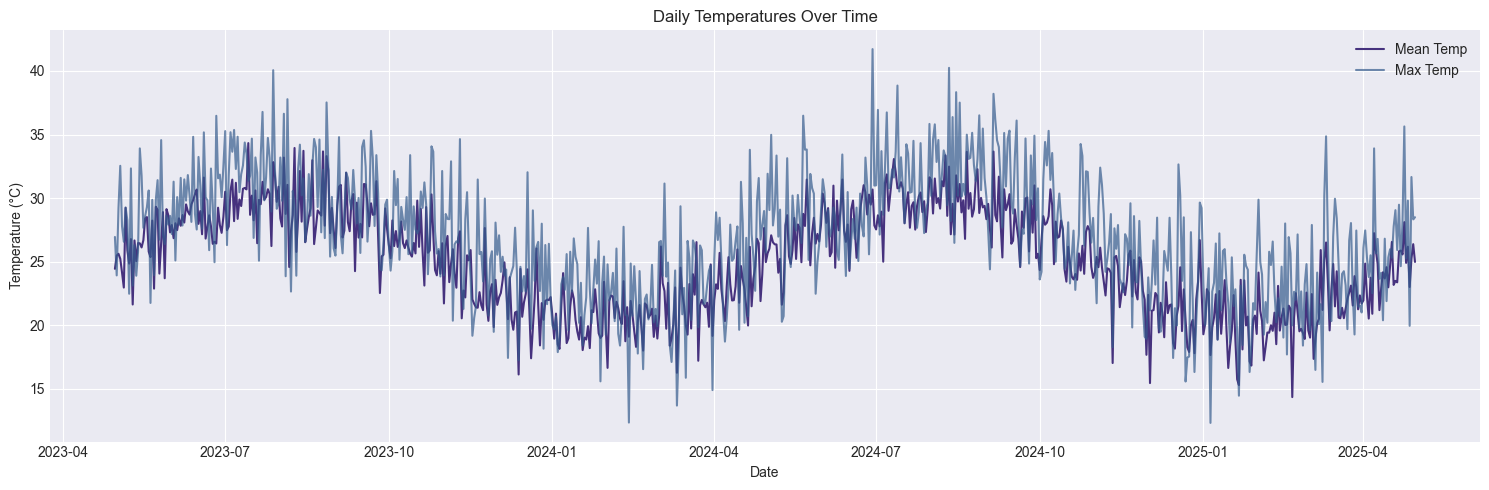

In [3]:
print("\n--- 3. Time Series Visualization of Raw Data ---")

# Plot temperature
plt.figure(figsize=(15, 5))
plt.plot(df_merged.index, df_merged['temperature_2m_mean'], label='Mean Temp')
plt.plot(df_merged.index, df_merged['temperature_2m_max'], label='Max Temp', alpha=0.7)
plt.title('Daily Temperatures Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/temp_time_series.png')
plt.show()

# Plot precipitation sum
plt.figure(figsize=(15, 5))
plt.plot(df_merged.index, df_merged['precipitation_sum'], label='Precipitation Sum (mm)', color='blue')
# Overlay flood events as markers
flood_dates = df_merged[df_merged['flood_event'] == 1].index
plt.scatter(flood_dates, df_merged.loc[flood_dates, 'precipitation_sum'],
            color='red', marker='o', s=50, label='Flood Event', zorder=5)
plt.title('Daily Precipitation Sum Over Time with Flood Events')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/precipitation_time_series.png')
plt.show()

# Plot wind direction (may need special handling if it's circular data, but for now as is)
plt.figure(figsize=(15, 5))
plt.plot(df_merged.index, df_merged['wind_direction_10m_dominant'], label='Dominant Wind Direction (degrees)', color='green', alpha=0.7)
plt.title('Dominant Wind Direction Over Time')
plt.xlabel('Date')
plt.ylabel('Degrees')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/wind_direction_time_series.png')
plt.show()

## 4. Initial Correlation Analysis ##

Let's compute the correlation matrix for the raw climate variables.

In [ ]:
print("\n--- 4. Initial Correlation Analysis ---")

# Select only the numerical climate columns for correlation
climate_cols = [
    'temperature_2m_mean',
    'temperature_2m_max',
    'wind_direction_10m_dominant',
    'precipitation_sum',
    'rain_sum'
]

# Ensure these columns exist in your dataframe before calculating correlation
existing_climate_cols = [col for col in climate_cols if col in df_merged.columns]
if not existing_climate_cols:
    print("Warning: No climate columns found for correlation analysis. Check your dataframe columns.")
else:
    correlation_matrix = df_merged[existing_climate_cols].corr()

    print("\nMatriz de Correlação das Variáveis Climáticas (Raw):")
    print(correlation_matrix)

    # Visualize the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriz de Correlação das Variáveis Climáticas (Raw Data)')
    plt.savefig('../reports/figures/raw_correlation_heatmap.png')
    plt.show()

# Correlation with the target variable (flood_event)
# This uses the current (unengineered) features
target_correlation = df_merged[existing_climate_cols].corrwith(df_merged['flood_event']).sort_values(ascending=False)
print("\nCorrelação das Variáveis Climáticas com 'flood_event' (Raw):")
print(target_correlation)

# Interpretation:
# - Look for highly correlated features (e.g., precipitation_sum and rain_sum are 1.0, temperature_mean and temperature_max are high).
# - This indicates redundancy. You'll likely drop one of these highly correlated pairs.
# - Observe initial correlations with 'flood_event'. They might be weak now, but will likely improve with feature engineering (lagged/rolling sums).

## 5. Summary and Next Steps

This initial EDA gives us a solid understanding of the raw data.

- We've identified potential missing values and data ranges.
- We've seen the time series patterns of the climate variables.
- The correlation matrix highlighted strong redundancies (e.g., precipitation_sum and rain_sum, temperature_2m_mean and temperature_2m_max).
- The raw features show relatively weak correlation with flood_event, which is expected before proper feature engineering for time-series.
## Next Steps:
Go to 02_feature_engineering_exploration.ipynb to apply feature engineering techniques, especially creating lagged and rolling features, which are critical for time-series prediction problems like flood forecasting.